In [4]:
import sys
sys.path.append('/home/zy/python_project/mms')  # 替换为 alpa_serve 的实际路径

from alpa_serve.trace import Trace

fixed_rate_scale = 2e-3
fixed_cv_scale = 2
trace_dir = "/home/zy/data/datasets/azurefunctions-dataset2019/azure_v1.pkl"
model_set = ["bert-6.7b", "moe-5.3b", "bert-2.6b", "moe-2.4b", "bert-1.3b", "moe-1.3b"]
fixed_num_modelset = 1
model_types = model_set * fixed_num_modelset
model_names = sum([[f"{model_type}-{i}" for model_type in model_set] for i in range(fixed_num_modelset)], [])

arrival_process_kwargs = {"rate_scale": fixed_rate_scale,
                          "cv_scale": fixed_cv_scale,
                          "trace_dir": trace_dir}

azure_v1_trace_dir = arrival_process_kwargs["trace_dir"]
azure_v1_trace = Trace("azure_v1", azure_v1_trace_dir)
train_replays = azure_v1_trace.replay(model_names,
                                        model_mapping_strategy="stripe",
                                        arrival_distribution="gamma",
                                        start_time="0.0.0",
                                        end_time="5.0.0",
                                        interval_seconds=60,
                                        rate_scale_factor=arrival_process_kwargs["rate_scale"],
                                        cv_scale_factor=arrival_process_kwargs["cv_scale"])

Reading takes: 4.91222357749939s.
Sliced trace stats: #functions: 72359, total invocations: 4614140645, max: 613251046, min: 0, avg: 63767.34


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize(trace_replay, n_interval=100):
    assert np.all(trace_replay.arrivals > trace_replay.start_seconds), \
        f"arrivals: {np.argwhere(np.isnan(trace_replay.arrivals))}, " \
        f"start_seconds: {trace_replay.start_seconds}"
    plt.figure()
    plt.hist(trace_replay.arrivals, bins=np.linspace(trace_replay.start_seconds, trace_replay.end_seconds,
                                                n_interval),
                alpha=0.8, label=trace_replay.model)
    plt.title("Sample requests histogram (bin size = 0.1s)")
    plt.ylabel("#requests")
    plt.xlabel("time (s)")
    plt.legend()
    plt.ylim(0, 200)
    fig = plt.gcf()
    figure_size = (8, 4)
    fig.set_size_inches(figure_size)
    plt.show()
    # fig_folder = "plots"
    # os.makedirs(fig_folder, exist_ok=True)
    # fig_name = f"{self.model}-{self.trace_name}-{self.arrival_distribution}-" \
    #            f"{self.start_time}-{self.end_time}-{self.interval_seconds}-" \
    #            f"({self.rate_scale_factor}, {self.cv_scale_factor}," \
    #            f"{self.time_scale_factor}, {self.replication_factor}).png"
    # fig.savefig(os.path.join(fig_folder, fig_name), bbox_inches='tight')
    # plt.close()

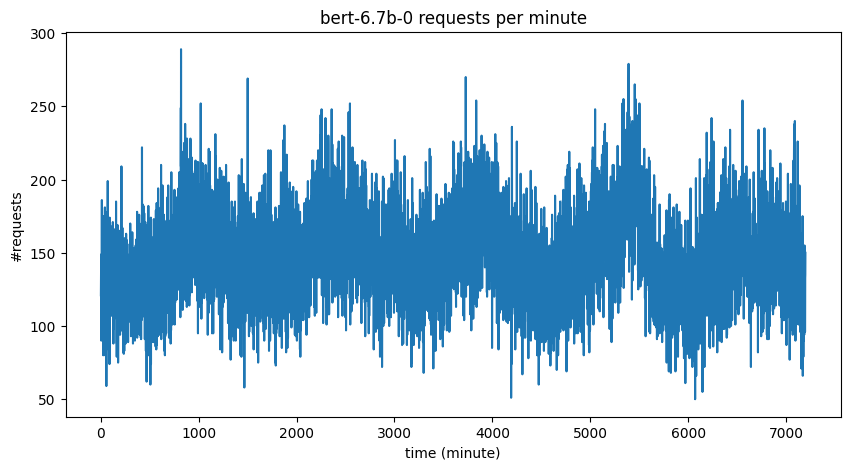

In [6]:
from alpa_serve.trace import Trace, TraceReplay
from typing import List, Dict

def cal_num_requests_per_interval(replays: Dict[str, TraceReplay],
                                  model_name: str,
                                  duration: int,
                                  interval: int) -> List[int]:
    '''
    计算每个时间段内的请求数
    '''
    num_intervals = duration // interval
    num_requests = [0] * num_intervals
    arrival_process = replays[model_name]
    for arrival_time in arrival_process.arrivals:
        interval_index = int((arrival_time - arrival_process.start_seconds) // interval)
        num_requests[interval_index] += 1
    return num_requests

model_name = "bert-6.7b-0"
model_1_requests = cal_num_requests_per_interval(train_replays, model_name, 3600 * 24 * 5, 60)

# 画出model_1的折线图
plt.figure(figsize=(10, 5))
plt.plot(model_1_requests)
plt.title(f"{model_name} requests per minute")
plt.ylabel("#requests")
plt.xlabel("time (minute)")
plt.show()

In [92]:
from autots import AutoTS
import pandas as pd

# 用AutoTS的ARIMA来训练和预测
# 创建时间索引
time_index = pd.date_range(start='2022-01-01', periods=len(model_1_requests), freq='T')  # 'T' 表示分钟频率
request_data = pd.DataFrame({'requests': model_1_requests}, index=time_index)

model = AutoTS(
    forecast_length=5,             # 设置预测的长度为 5 个时间单位
    frequency='infer',              # 自动检测数据频率
    ensemble=None,                  # 不使用集成模型
    model_list=['ARIMA'],           # 指定只使用 ARIMA 模型
    transformer_list=None,        # 不使用数据转换器
    verbose=False,                   # 关闭输出
    num_validations=1               # 设置验证数量为1
)

# 训练模型
model = model.fit(request_data)

Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 3 in generation 0: ARIMA
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 51 in generation 9: ARIMA


预测结果：
                     requests
2022-01-06 00:00:00     134.0
2022-01-06 00:01:00     131.0
2022-01-06 00:02:00     132.0
2022-01-06 00:03:00     134.0
2022-01-06 00:04:00     134.0


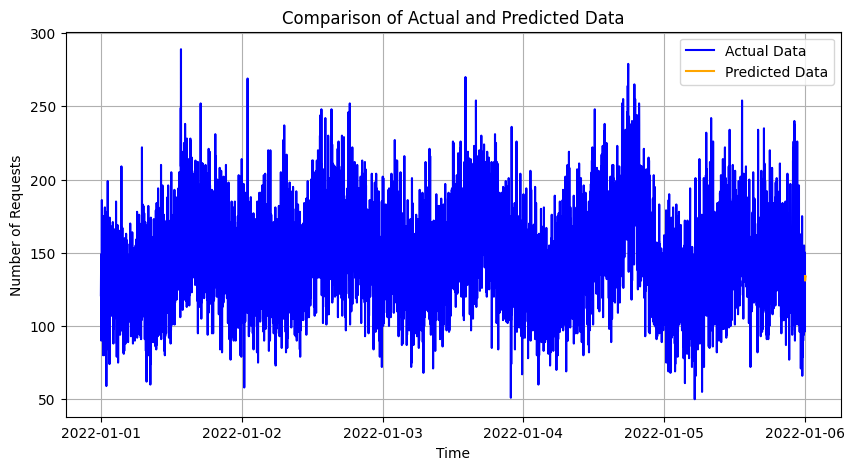

In [93]:
# 生成预测
prediction = model.predict()
forecast = prediction.forecast

# 输出结果
print("预测结果：")
print(forecast)

# 可视化结果
plt.figure(figsize=(10, 5))
plt.plot(request_data.index, request_data['requests'], label='Actual Data', color='blue')  # 绘制实际数据
plt.plot(forecast.index, forecast.values, label='Predicted Data', color='orange')  # 绘制预测数据
plt.title('Comparison of Actual and Predicted Data')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.grid()
plt.show()

In [94]:
# 查看模型信息
print("模型信息：")
print(model)

模型信息：
Initiated AutoTS object with best model: 
ARIMA
{'fillna': 'fake_date', 'transformations': {'0': 'HistoricValues', '1': 'ClipOutliers'}, 'transformation_params': {'0': {'window': None}, '1': {'method': 'clip', 'std_threshold': 1, 'fillna': None}}}
{'p': 2, 'd': 0, 'q': 12, 'regression_type': None}
Validation: 0, 1
SMAPE: 9.625922777621657, 17.866073210044572
MAE: 11.8, 22.8
SPL: 0.25323193916349807, 0.20821557673348665


In [130]:
train_replays_next = azure_v1_trace.replay(model_names,
                                    model_mapping_strategy="stripe",
                                    arrival_distribution="gamma",
                                    start_time="5.0.0",
                                    end_time="5.1.0",
                                    interval_seconds=3600,
                                    rate_scale_factor=arrival_process_kwargs["rate_scale"],
                                    cv_scale_factor=arrival_process_kwargs["cv_scale"])

Sliced trace stats: #functions: 72359, total invocations: 32807479, max: 5374848, min: 0, avg: 453.40


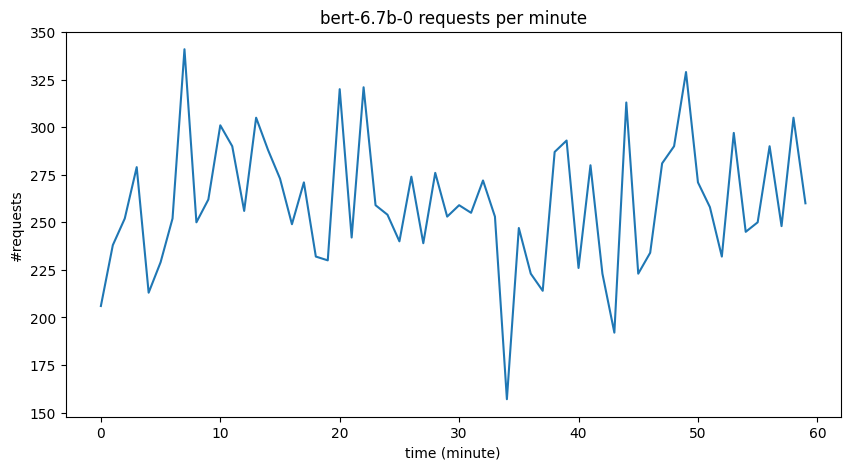

In [131]:
from alpa_serve.trace import Trace, TraceReplay
from typing import List, Dict

def cal_num_requests_per_interval(replays: Dict[str, TraceReplay],
                                  model_name: str,
                                  duration: int,
                                  interval: int) -> List[int]:
    '''
    计算每个时间段内的请求数
    '''
    num_intervals = duration // interval
    num_requests = [0] * num_intervals
    arrival_process = replays[model_name]
    for arrival_time in arrival_process.arrivals:
        interval_index = int((arrival_time - arrival_process.start_seconds) // interval)
        num_requests[interval_index] += 1
    return num_requests

model_name = "bert-6.7b-0"
model_1_requests = cal_num_requests_per_interval(train_replays_next, model_name, 3600, 60)

# 画出model_1的折线图
plt.figure(figsize=(10, 5))
plt.plot(model_1_requests)
plt.title(f"{model_name} requests per minute")
plt.ylabel("#requests")
plt.xlabel("time (minute)")
plt.show()

In [96]:
model_name = "bert-6.7b-0"
model_1_requests_next = cal_num_requests_per_interval(train_replays_next, model_name, 3600, 60)

In [122]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# 假设初始训练数据在 request_data 中
# 先用 ARIMA 构建初始模型
initial_model = ARIMA(request_data['requests'], order=(2, 0, 10))
model_fit = initial_model.fit()

# 初始化预测列表
predict_list = []

# 使用 request_data 最后一个值开始预测
current_data = request_data.copy()  # 创建数据的副本以进行滚动预测

for i in range(len(model_1_requests_next)):
    # 单步预测
    forecast_result = model_fit.get_forecast(steps=1)
    forecast_value = forecast_result.predicted_mean.iloc[0]
    
    # 将预测值添加到预测列表
    predict_list.append(forecast_value)
    
    # 打印预测结果
    print(f"预测结果：{forecast_value}")
    
    # 更新当前数据，将新的预测值作为下一个时间步的新数据点
    new_timestamp = current_data.index[-1] + pd.Timedelta(minutes=1)
    new_data = pd.DataFrame({'requests': [model_1_requests_next[i]]}, index=[new_timestamp])
    current_data = pd.concat([current_data, new_data])
    
    # 更新模型：使用新加入的数据重新拟合 ARIMA 模型
    model_fit = ARIMA(current_data['requests'], order=(2, 0, 10)).fit()
    
    # 保持数据长度合理，避免内存过大，可以选择保留最新 N 条数据
    current_data = current_data[-50:]  # 例如只保留最新 100 条数据

    # if i==5:
    #     print("current_data:", current_data)
    #     break

print("滚动预测结果列表：", predict_list)


预测结果：127.65200074138278
预测结果：138.76704709320194
预测结果：143.53053852975077
预测结果：271.0625334901856
预测结果：316.0939961375662
预测结果：158.89009424167796
预测结果：258.9621285969845
预测结果：230.3001989637907
预测结果：181.96773038485856
预测结果：296.30089233418767
预测结果：293.7096777725129
预测结果：285.6396670669244
预测结果：302.5903977080774
预测结果：199.5956303869244
预测结果：259.36479664500644
预测结果：227.37232119267838
预测结果：252.68912615996885
预测结果：274.2390210451039
预测结果：260.6075599878388
预测结果：318.30566443928296
预测结果：230.48527497689963
预测结果：257.5466218028274
预测结果：188.45558513903728
预测结果：269.740016553338
预测结果：259.7148476461083
预测结果：289.4673316640085
预测结果：260.4351306059271
预测结果：241.23437166403974
预测结果：189.34277217792672
预测结果：243.37632436853806
预测结果：266.73689433166123
预测结果：257.304708648933
预测结果：243.97154942835928
预测结果：246.60316541095196
预测结果：218.8473160500117
预测结果：250.8147596775488
预测结果：257.515666692444
预测结果：242.97205301252785
预测结果：246.18594711425612
预测结果：243.49160007266755
预测结果：200.31995582706617
预测结果：283.03133744947894
预测结果：296.64308

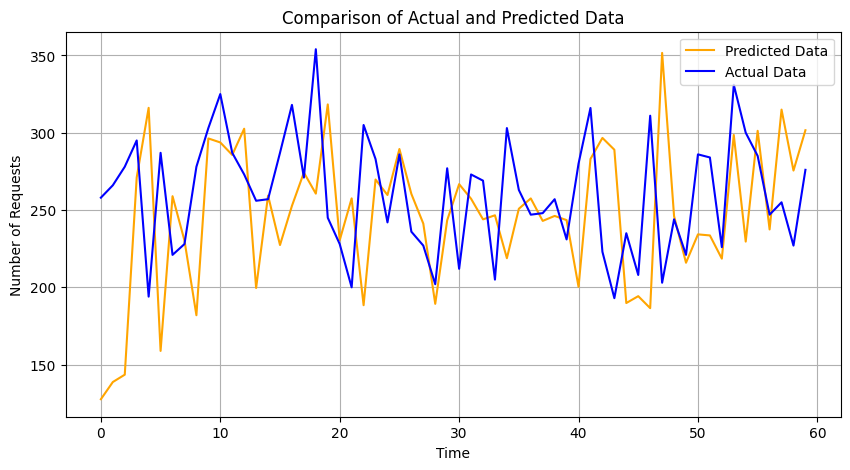

In [123]:
# 画出predict_list和model_1_requests_next的折线图
plt.figure(figsize=(10, 5))
plt.plot(predict_list, label='Predicted Data', color='orange')  # 绘制预测数据
plt.plot(model_1_requests_next, label='Actual Data', color='blue')  # 绘制实际数据
plt.title('Comparison of Actual and Predicted Data')
plt.xlabel('Time')
plt.ylabel('Number of Requests')
plt.legend()
plt.grid()
plt.show()

In [30]:
for replay in train_replays:
    train_replays[replay].report_stats()
    train_replays[replay].visualize()

Trace for bert-6.7b-0, duration: (0, 1, 0, 0), 3600 (s), #arrivals: 9106, arrival distribution: gamma, generation interval: 3600, scale factor: (0.002, 10, 1.0, 1). overall rate: 2.53, overall cv: 9.23.
Trace for moe-5.3b-0, duration: (0, 1, 0, 0), 3600 (s), #arrivals: 8148, arrival distribution: gamma, generation interval: 3600, scale factor: (0.002, 10, 1.0, 1). overall rate: 2.26, overall cv: 10.24.
Trace for bert-2.6b-0, duration: (0, 1, 0, 0), 3600 (s), #arrivals: 10199, arrival distribution: gamma, generation interval: 3600, scale factor: (0.002, 10, 1.0, 1). overall rate: 2.83, overall cv: 10.23.
Trace for moe-2.4b-0, duration: (0, 1, 0, 0), 3600 (s), #arrivals: 10711, arrival distribution: gamma, generation interval: 3600, scale factor: (0.002, 10, 1.0, 1). overall rate: 2.98, overall cv: 9.01.
Trace for bert-1.3b-0, duration: (0, 1, 0, 0), 3600 (s), #arrivals: 11536, arrival distribution: gamma, generation interval: 3600, scale factor: (0.002, 10, 1.0, 1). overall rate: 3.20, 

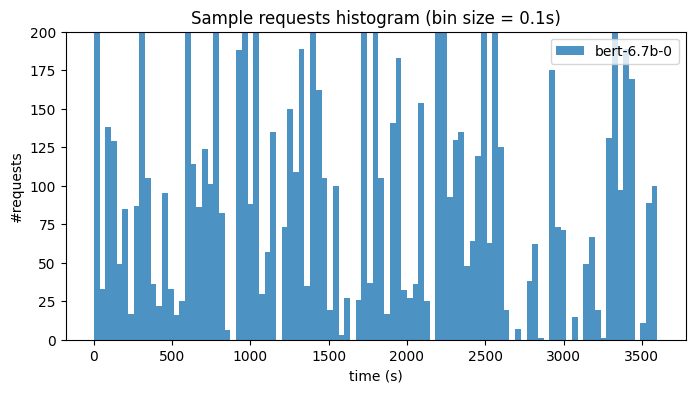

In [31]:
visualize(train_replays["bert-6.7b-0"])

In [19]:
import sys
sys.path.append('/home/zy/python_project/mms')  # 替换为 alpa_serve 的实际路径

from alpa_serve.simulator.workload import Workload, GammaProcess
from collections import OrderedDict
from alpa_serve.trace import Trace, TraceReplay
import numpy as np

rate_distribution = "power_law"
arrival_process = "gamma"
arrival_process_kwargs = {"cv": 2}
total_rate = 10
duration = 3600 * 10
interval_seconds = 600

# 设置峰值率和基础率
peak_rate = 2  # 峰值期间的请求率
base_rate = 0.2  # 其他时间的基础请求率

fixed_num_devices = 32
fixed_num_modelset = 1
fixed_slo_scale = 5

model_set = ["bert-6.7b", "moe-5.3b", "bert-2.6b", "moe-2.4b", "bert-1.3b", "moe-1.3b"]
model_types = model_set * fixed_num_modelset
model_names = sum([[f"{model_type}-{i}" for model_type in model_set] for i in range(fixed_num_modelset)], [])

num_models = len(model_names)

peak_times_list = [
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]

# 定义到达过程
arrival_processes = []
if rate_distribution == "power_law":
    alpha = 0.1
    s = sum((x+1)**(-alpha) for x in range(num_models))
    base = total_rate / s
    rates = [base * ((x+1) ** (-alpha)) for x in range(num_models)]
if arrival_process == "gamma":
    for i in range(num_models):
        # 设置波峰的时间段（例如：100-200秒和300-400秒）
        num_intervals = duration // interval_seconds
        # # 随机选择波峰的数量
        # num_peaks = np.random.randint(1, 3600 * 10 / 600)
        # # 随机选择波峰的时间段
        # peak_times = np.random.choice(num_intervals, num_peaks, replace=False)
        peak_times = peak_times_list[i]
        distribution = []
        for t in range(duration // interval_seconds):
            if t in peak_times:
                rate = peak_rate * rates[i]
            else:
                rate = base_rate * rates[i]
            distribution.append(GammaProcess(rate, arrival_process_kwargs["cv"]))
        arrival_processes.append(distribution)

replays = OrderedDict()
start_time = "0.0.0"
end_time = f"0.{int(duration / 3600)}.0"
start_d, start_h, start_m = Trace.timestr_to_dhm(start_time)
end_d, end_h, end_m = Trace.timestr_to_dhm(end_time)
start_timestamp_seconds = start_d * 24 * 60 * 60 + start_h * 60 * 60 + start_m * 60
end_timestamp_seconds = end_d * 24 * 60 * 60 + end_h * 60 * 60 + end_m * 60

seed = 0
for m in range(len(arrival_processes)):
    arrivals = []
    arrival_distribution_params = []
    for i, distribution in enumerate(arrival_processes[m]):
        if distribution is None:
            arrival_distribution_params.append(None)
            continue
        start = i * interval_seconds + start_timestamp_seconds
        arrivals.extend(distribution.generate_arrivals(start, interval_seconds, seed))
        # if DEBUG:
        #     arrivals.extend(distribution.generate_arrivals(0, 1.0e9, seed))
        #     self.visualize_inter_arrival(np.array(arrivals), "test")
        arrival_distribution_params.append(distribution.params())
        seed += 1
    replays[model_names[m]] = TraceReplay(model_names[m],
                             np.array(arrivals),
                             "synthetic",
                             start_time,
                             end_time,
                             interval_seconds,
                             arrival_distribution="power_law",
                             arrival_distribution_params=arrival_distribution_params)

In [20]:
for replay in replays:
    replays[replay].report_stats()
    replays[replay].visualize()

Trace for bert-6.7b-0, duration: (0, 10, 0, 0), 36000 (s), #arrivals: 33872, arrival distribution: power_law, generation interval: 600, scale factor: (1.0, 1.0, 1.0, 1). overall rate: 0.94, overall cv: 3.17.
Trace for moe-5.3b-0, duration: (0, 10, 0, 0), 36000 (s), #arrivals: 31009, arrival distribution: power_law, generation interval: 600, scale factor: (1.0, 1.0, 1.0, 1). overall rate: 0.86, overall cv: 3.10.
Trace for bert-2.6b-0, duration: (0, 10, 0, 0), 36000 (s), #arrivals: 29781, arrival distribution: power_law, generation interval: 600, scale factor: (1.0, 1.0, 1.0, 1). overall rate: 0.83, overall cv: 3.17.
Trace for moe-2.4b-0, duration: (0, 10, 0, 0), 36000 (s), #arrivals: 29614, arrival distribution: power_law, generation interval: 600, scale factor: (1.0, 1.0, 1.0, 1). overall rate: 0.82, overall cv: 3.05.
Trace for bert-1.3b-0, duration: (0, 10, 0, 0), 36000 (s), #arrivals: 28172, arrival distribution: power_law, generation interval: 600, scale factor: (1.0, 1.0, 1.0, 1). 

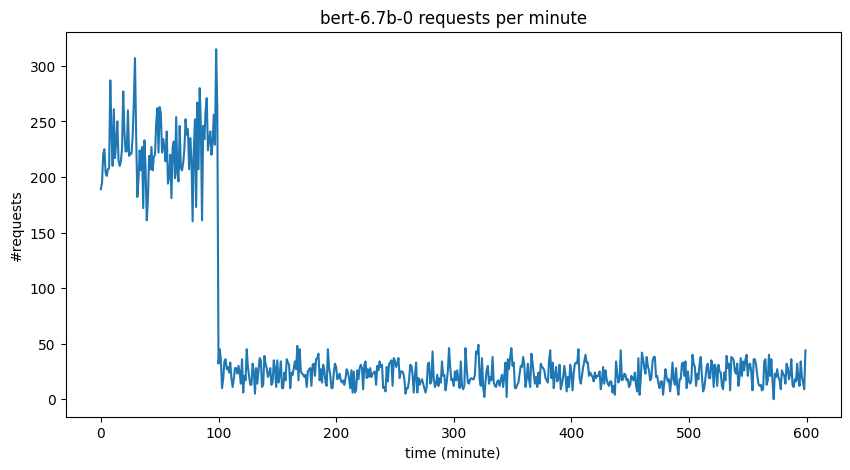

In [21]:
model_name = "bert-6.7b-0"
model_1_requests = cal_num_requests_per_interval(replays, model_name, 3600 * 10, 60)

# 画出model_1的折线图
plt.figure(figsize=(10, 5))
plt.plot(model_1_requests)
plt.title(f"{model_name} requests per minute")
plt.ylabel("#requests")
plt.xlabel("time (minute)")
plt.show()

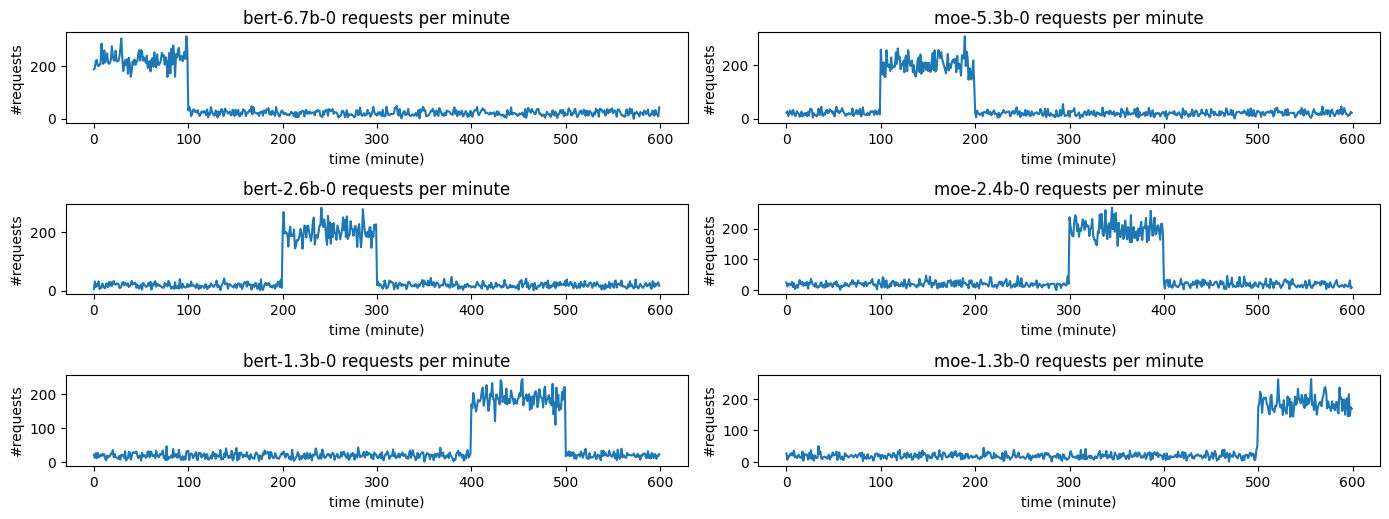

In [22]:
import matplotlib.pyplot as plt

# 创建子图布局，每行显示 2 个子图
num_models = len(model_name)
fig, axs = plt.subplots(nrows=(num_models + 1) // 2, ncols=2, figsize=(14, 10))
axs = axs.flatten()  # 将子图数组展平，方便迭代访问

# 生成并绘制每个模型的请求数折线图
for i, model_name in enumerate(model_names):
    # 假设每个模型的请求数据通过函数 cal_num_requests_per_interval 计算得到
    model_requests = cal_num_requests_per_interval(replays, model_name, 3600 * 10, 60)
    
    # 绘制到对应子图
    axs[i].plot(model_requests, label=f"{model_name} requests")
    axs[i].set_title(f"{model_name} requests per minute")
    axs[i].set_ylabel("#requests")
    axs[i].set_xlabel("time (minute)")
    # axs[i].legend()

# 移除多余的空白子图
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# 调整布局并显示图表
plt.tight_layout()
plt.show()